# imports

In [4]:
!pip install openai
!pip install PyMuPDF
!pip install gradio

In [5]:
import openai
import datetime
import gradio
from openai import OpenAI
import json
from google.colab import files
import io
import fitz
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')


# API Keys

In [6]:
# Replace 'your-api-key' with your actual API key
# backup key1:
# backup key2:
# backup key3:
client = OpenAI(api_key="")

# Part I

## Basic ChatGPT API Call

In [ ]:
response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": "act as a world class comedian, you answer anything with a rethoric question and funny answer"},
            {"role": "user", "content": "Tell me a the story of google in 100 words"}
        ])

In [ ]:
# lets see how the response looks like
response.dict()

In [ ]:
# lets navigate to the message/answer
answer = response.dict()["choices"][0]["message"]["content"]
answer

'So you want me to condense the epic tale of Google, the search engine that turned into a global empire, into just 100 words? Can you believe that a company originally called Backrub would become a verb synonymous with searching? Did Larry Page and Sergey Brin know their little project would become the almighty Google? Did they high-five each other when they earned their first dollar? Did they expect to be in every browser and smartphone on the planet? And do they now have secret Google machines in everyone’s brains? The story of Google is like a suspenseful mystery novel, but with a lot of memes.'

## How the 'chatting' part works

The `conversation_log` is a Python list that stores a series of dictionary entries, each representing a message in a conversation.
The schema is designed by openAI, a convention we need to follow when using their API.
**Schema:**

- **role**: Indicates who sent the message. Either `"user"` or `"assistant"` or `"system"`.
- **content**: The actual message text.

In [ ]:
# conversation log aka 'shortterm memory'. Each message follows a specific fomrat  (design choice by openAI that we need to follow)
#
conversation_log = [
    {"role": "user", "content": "Hi, I am Alex. may i introduce myself? "},
    {"role": "assistant", "content": "sure, go along!"},
    {"role": "user", "content": "I i have one dog called sally and I love cooking, i have an allergy against rice, pasta and bread, and i am a big fan of cabbage"},
    {"role": "assistant", "content": "nice to meet you!"}

]

In [ ]:
input = conversation_log + [{"role": "user", "content": "please suggest a recipie i can cook for myself tonight"}]

response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages= input)

In [ ]:
answer = response.dict()["choices"][0]["message"]["content"]
answer

##Two talking Bots

You can make multiple 'bots' talk to eachother simply by calling the API in a loop while maintaining the conversation_log/ shortterm memory.

In [ ]:
# wrap the API call into a function for easy re-use
def ask_chatgpt_statefull(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        presence_penalty = 1
    )
    # Convert the response to a dictionary
    response = response.dict()

    # Accessing the content of the response
    return response['choices'][0]['message']['content']

Lets run an LLM in a loop!

In [ ]:
# initialize the conversation
conversation_log = [{"role": "user", "content":  "You are interviewing me for a job in computer science. Ask me Question to test my qualification"}]

for i in range(4):
  # call chatGPT
  description = ask_chatgpt_statefull(conversation_log)

  # add response to conversation_log in the chatgpt schema & print for review
  # Note, we add instructions for the second API call at the end
  conversation_log.append({"role": "assistant", "content":description+ ". So, dear appllicant please asnwer my question:" })
  print("because bot: ", description, "\n__________")


 # call the chatGPT API again with the updated conversation_log
  why_question = ask_chatgpt_statefull(conversation_log)
  print("why bot: ", why_question, "\n=========")

  conversation_log.append({"role": "user", "content":why_question })

In [ ]:
conversation_log

## Leveraging Language Models (LLM) for Structured Data Extraction

In practice this could mean to extract sentiment from text, emotions from images, or categorise product descriptions.

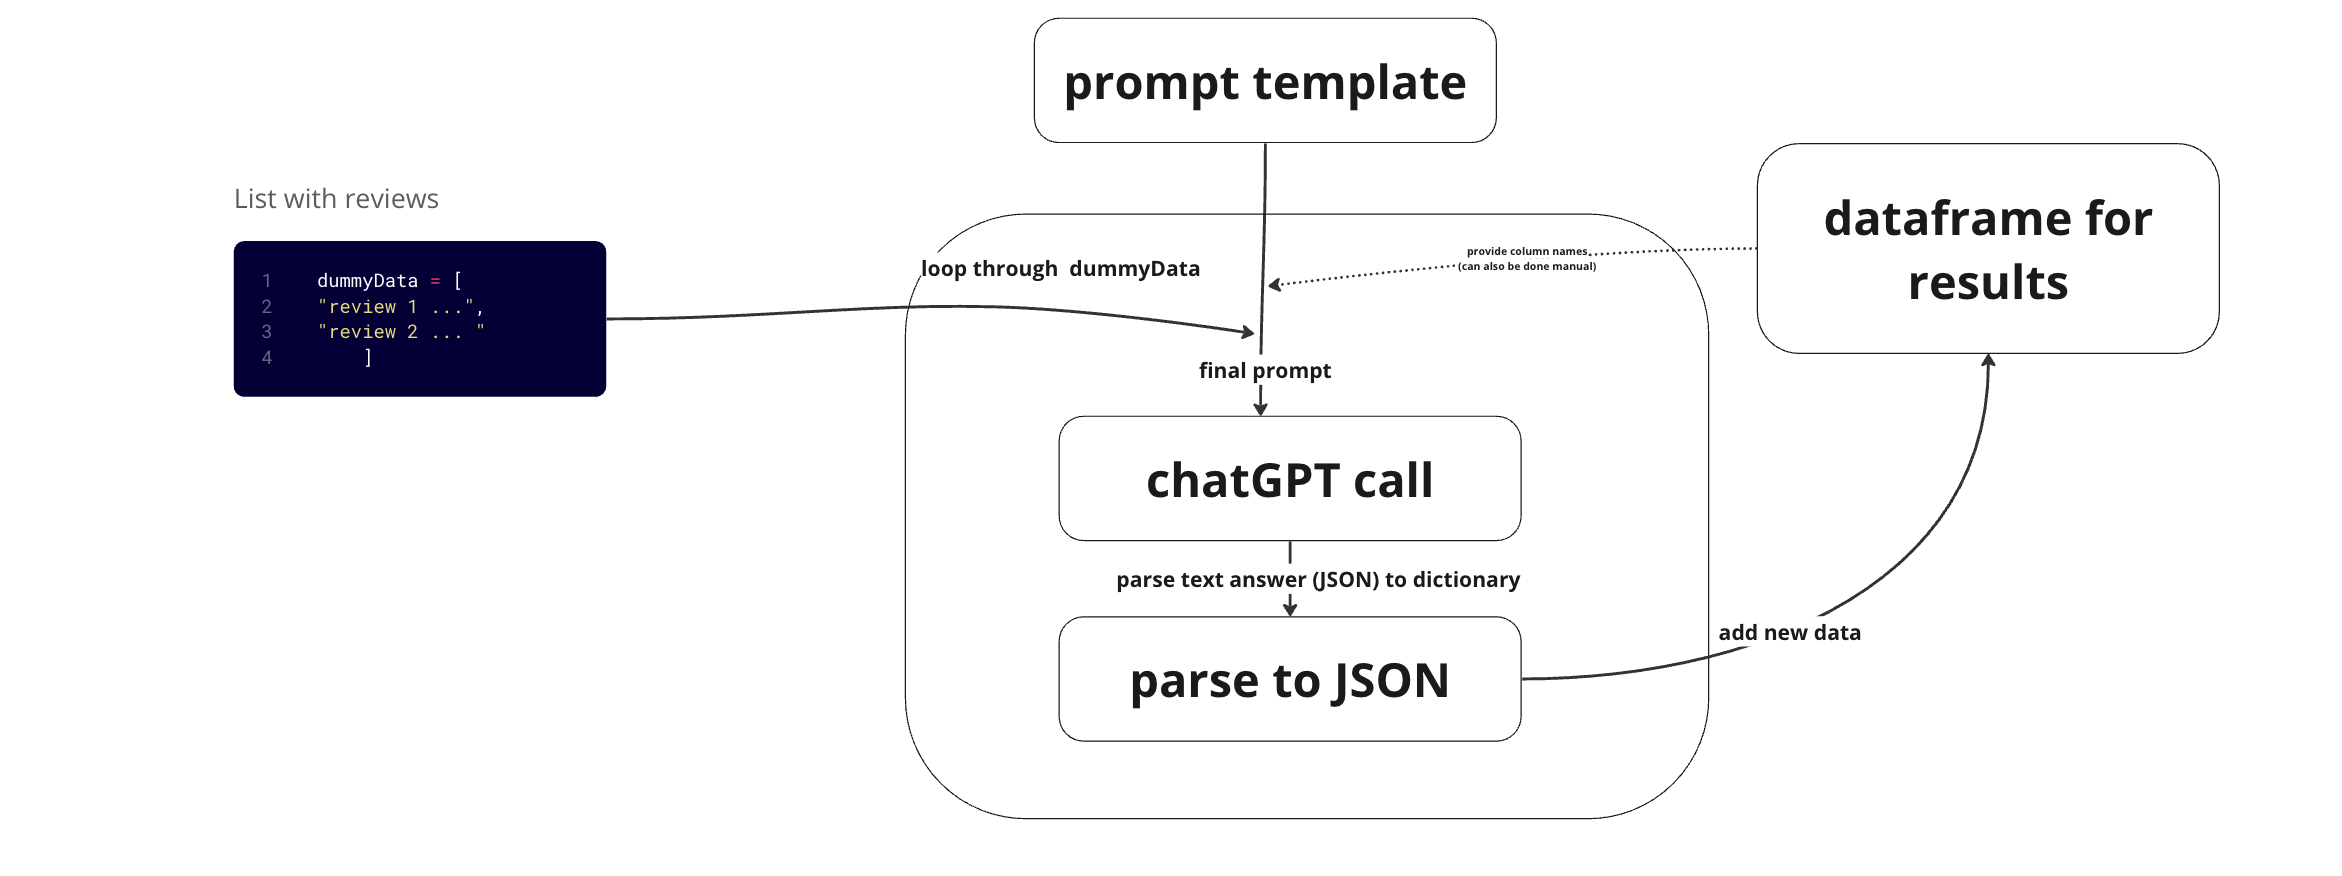

In this example we loop throuhg a list of unstructured amazon product reviews with the goal to add them to dataframe where we categorize and tag each review.

##### DummyData (a list of random amazon reviews)

In [ ]:
dummyData = [
    """1.0 out of 5 stars Overpriced, No after service Edit: I purchased cafe birraio machine which is excellent in every term.
    Thanks Amazon for great service. Seller was not able to solve problem. Returned it.
    No after sales support. No support from seller or intermediate platform. If it fails you are at your own. My machine failed in 3 months.
    Most important: If you are buying this just remember you are on your own as there is no seller support post sales and they don’t have any idea what’s going on and they don’t reply as well. So warranty looks like on papers only, and looks there will not be any support if anything happens.
    This is one of the worst performing espresso machine. Highly overpriced. Steam pressure is very low, You don’t get well frothed milk. It need a 20-25 minute break after 2 cup of coffee because it’s boiler gets over heated.
    5 people found this helpful""",
    """ 5.0 out of 5 stars Prima di lasciare questa recensione ho aspettato qualche mese per provarla bene. Devo dire che sono rimasto soddisfatto! La macchina si presenta bene dal punto di vista estetico, solida, con corpo in acciaio inox e qualche plastica, di dimensioni appropriate e non invadenti. Il macinino dopo mesi di utilizzo funziona egregiamente. Lo scaldatazze superiore è discreto. Il caffè viene estratto in maniera decisamente buona, ad una temperatura ottimale. A tal proposito consiglio, dopo l'accensione, di mettere la tazzina del caffè sotto l'erogatore in modo che si scaldi bene quando esegue il ciclo di pulizia e dopo svuotarla e rimetterla di nuovo sotto l'erogatore avviando un altro ciclo di pulizia: noterete che questa volta l'acqua esce con sbuffi di vapore ed in maniera meno regolare; da questo momento in poi ad ogni erogazione di acqua questa esce regolarmente ed in maniera appropriata per un'estrazione ottimale del caffè. Consiglio questa manovra ad ogni nuova accensione della macchina. Ho letto in alcune recensioni che è stato notato un difetto di erogazione quando si preparano 2 caffè, nel senso che uscirebbe maggiormente dall'ugello di sinistra: nel mio caso questo non è mai accaduto come potete notare dal video allegato. A questo proposito consiglierei di valutare con attenzione la collocazione della macchina perfettamente in piano e, soprattutto, prima di effettuare la pressatura di utilizzare un distributore di caffè che consenta di livellarlo nel portafiltro in maniera ottimale per l'estrazione. Per quanto riguarda il montalatte lo trovo buono anche se non eccelso. Il filtro addolcitore dopo 2 mesi di utilizzo l'ho sostituito con un filtro DLSC002 marca Queta (acquistato sempre su Amazon), che alla prova funziona egregiamente e si adatta alla macchina meglio di quello in dotazione che probabilmente era un De Longhi originale ma che sembrava meno stabile e in più costa molto meno della metà. Attenzione perché nella descrizione del filtro non viene mai citata la compatibilità con la macchina Ariete 1313 e questo potrebbe far desistere dall'acquisto ed anch'io ero un po' titubante, ma avendo notato nella descrizione che le misure del filtro combaciavano con quello in dotazione mi sono deciso ad acquistarlo. Un'ultima considerazione per la riuscita ottimale di un buon caffè è di provare la miscela in grani che più si adatta al vostro gusto e di sperimentare per ogni miscela il giusto grado di macinazione, la giusta quantità di acqua da programmare per l'erogazione e la giusta quantità di caffè da caricare nel filtro: possono sembrare banalità ma vi assicuro che sono fondamentali. All'inizio bisogna sperimentare e poi una volta trovato il giusto equilibrio diventa tutto meccanico e semplice. Alla luce anche del fattore prezzo (ho acquistato la macchina in offerta pagandola intorno ai 250 euro) direi che è un ottimo acquisto e la consiglio.
    Read less
    12 people found this helpful""",
    """5.0 out of 5 stars Zuverlässige und erschwingliche Bleistifte für den alltäglichen Gebrauch
    Reviewed in Germany on 5 October 2023
    Size Name: 1 stück (30er Pack)Verified Purchase
    Ich habe vor kurzem die Amazon Basics holzgefassten Bleistifte gekauft und möchte meine Erfahrungen mitteilen.
    Die Bleistifte bestehen aus hochwertigem Holz und haben eine angenehme Haptik. Sie liegen gut in der Hand und sind leicht zu handhaben. Die Mine ist mittelhart und ermöglicht ein präzises Schreiben und Zeichnen. Die Bleistifte lassen sich leicht spitzen und die Mine bricht nicht leicht ab.
    Die Haltbarkeit der Bleistifte ist beeindruckend. Trotz des täglichen Gebrauchs halten sie erstaunlich lange. Ich habe bereits zahlreiche Seiten mit ihnen gefüllt und sie funktionieren immer noch einwandfrei.
    Ein weiterer Vorteil ist der angebrachte Radiergummi. Er ist von guter Qualität und ermöglicht ein einfaches Radieren von Fehlern und Korrekturen. Die Radierer hinterlassen keine unschönen Spuren auf dem Papier und sind ausreichend groß.
    Die Verpackung der Bleistifte ist einfach und zweckmäßig. Sie kommen in einer einfachen Plastikhülle, die die Bleistifte schützt und sicher aufbewahrt.
    Der Preis der Amazon Basics holzgefassten Bleistifte ist unschlagbar. Sie bieten ein ausgezeichnetes Preis-Leistungs-Verhältnis, insbesondere wenn man bedenkt, dass es sich um ein Set von 30 Bleistiften handelt.
    Ob für den Schulgebrauch, das Büro oder den alltäglichen Gebrauch zu Hause - die Amazon Basics holzgefassten Bleistifte sind eine zuverlässige Wahl. Sie bieten eine solide Leistung und sind erschwinglich. Ich kann diese Bleistifte jedem empfehlen, der eine kostengünstige Option für den täglichen Gebrauch sucht und dabei nicht auf Qualität verzichten möchte.
    Read less
    5 people found this helpful""",
    """5.0 out of 5 stars Top Lampe! Perfekt.Reviewed in Germany on 27 April 2024
    Verified Purchas Wirklich toll diese Lampe. Habe schon die zweite davon gekauft. Gute Helligkeit. Diverse Farbmodi. Leicht zu installieren (geht fast automatisch, WLAN etc.). Durch die App hat man immer alles unter Kontrolle. Gut, die Optik der Lampe ist nicht so ganz stylisch. Das könnte man anders designen, aber gut. Sie tut, was sie soll. Kleiner Kritikpunkt: In der App müsste man direkt sehen, ob die Lamp bereits eingeschaltet ist (ähnlich wie bei FRITZ! von AVM). Da ist der Regler dann grün. Hier muss man erst in der App in die Oberfläche der Lampe klicken. Aber das ist nur ein kleiner Punkt. Sonst kann ich sie nur empfehlen."""
]

##### Code

1. Create a Dataframe to collect information extracted from the reviews

In [ ]:
# lets initialize a dataframe with the columns
# named after information we are intereded in
columnNames = ["productCategory", "reviewSentiment", "reviewSummaryEnglish", "priceValueRatio", "productName", "reviewSummarySpanish"]
dataCollection = pd.DataFrame(columns = columnNames)

2. (optional) Trun the empty dataframe into a dictionary and then into a JSON string. We can use that string to tell the LLM how we want the answer to be structured!

In [ ]:
# dataframe ->  dictionary -> text string
data_dict = dataCollection.to_dict(orient='list')
data_dict_json = json.dumps(data_dict).replace("[]", '""')

# lets take a look at the resulting string
data_dict_json

3. Assemble the prompt-template

In [ ]:
# this might get a bit longer
prompt_template = f"""
Your task is to analyse the product reviews from a webplatform you will see below. You should try
your best to determine infomration on these subjects {str(columnNames)}.

Please return you answer in the structure of a JSON. DO not add any comment or
thouhgts, only aswer with the json. Below is an example of how the JSON shall be
formated: {data_dict_json}.

the review text:
"""

4.  loop through the list of dummyData
*   construct the final prompt
*   call the LLM
*   parse the JSON part to a dict
*   add to dataCollection

In [ ]:
for review in dummyData:

  # construct final prompt
  final_prompt = prompt_template + review
  #print ("final prompt: ", final_prompt)

  # call the LLM, navigate to answer message
  response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "user", "content": final_prompt}
        ])


  answer = response.dict()["choices"][0]["message"]["content"]
  print("answer: ", answer)

  # parse the JSON part (might fail if llm makes a mistake)
  answer_dict = json.loads(answer)
  answer_df =  pd.DataFrame(answer_dict, index=[0])

  # add to dataframe
  dataCollection = pd.concat([dataCollection, answer_df], ignore_index=True)


In [ ]:
# lets see the result
dataCollection

# Part II

## chatGPT Vision

### utilities


In [47]:
from PIL import Image # python libary for image processing
from io import BytesIO
import base64

In [48]:
# turning an image to its b64 encoding (-> sending it as text)
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")  # You can change the format to PNG or other types if needed
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

### main part

In [50]:
# upload image and transform to PIL format
uploaded_img_vis = files.upload()
filename = next(iter(uploaded_img_vis))
image_vis = Image.open(BytesIO(uploaded_img_vis[filename]))

KeyboardInterrupt: 

In [49]:
def gpt_vision(vision_prompt, image_encoded):
  response = client.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": vision_prompt},
              { "type": "image_url",
                "image_url": {
                  "url": "data:image/jpeg;base64,"+ image_encoded,
                },
              },
            ],
          },
        ],
        max_tokens=800,
  )
  return response.choices[0].message.content

In [ ]:
base64_image = image_to_base64(image_vis)

In [ ]:
img_desc = gpt_vision("You are a model with vision capabilities. What materials were likly used for building the hous eon the image? Return a list of materials in the stlye of a python list [materia, material2] ", base64_image)

In [ ]:
img_desc

## TASK I: create a gptVision App
Brainstorm a idea for an simple gradio app utilizing gpt and gptVision

**The function to call the gptVision model**

In [51]:
def gpt_vision(vision_prompt, image_encoded):
  response = client.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": vision_prompt},
              { "type": "image_url",
                "image_url": {
                  "url": "data:image/jpeg;base64,"+ image_encoded,
                },
              },
            ],
          },
        ],
        max_tokens=800,
  )
  return response.choices[0].message.content

**The prompt template**
This is your instruction to the model what it should do. It has access to the image and the prompt you define below

In [ ]:
global gptVisionAppPromptTemplate
gptVisionAppPromptTemplate = """
Here is an image, try to count the number of people on the image.
 """

**This function is called when you click the "submit" button in the gradio app**

In [ ]:
def gptVisionApp(prompt, image):
  # encode to b64
  image_encoded = image_to_base64(image)

  global gptVisionAppPromptTemplate
  final_prompt = gptVisionAppPromptTemplate + prompt

  res = gpt_vision(final_prompt,image_encoded)

  #optionally collect results in a list (defined in the cell below)
  anwser_collection.append(res)
  return res


**Gradio App** This section initializes and launches the gradio app

In [ ]:
anwser_collection = []

# Gradio interface setup
iface = gradio.Interface(
    fn=gptVisionApp,
    inputs=[
        gradio.Textbox(label="Optional Text Prompt"),
        gradio.Image(type="pil", label="Upload Image" ),
    ],
    outputs=[
        gradio.Textbox(label="Output from ChatGPT Vision"),
    ],
    title="your app title",
    description="Upload an image and optionally add text to get a response from the ChatGPT Vision model."
)

# Run the interface
iface.launch(debug = True, share=True)

In [ ]:
# lets print the colelcted anwsers
print (anwser_collection)

OUR APP "what is next?"

In [ ]:
def gpt_vision(vision_prompt, image_encoded):
  response = client.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": vision_prompt},
              { "type": "image_url",
                "image_url": {
                  "url": "data:image/jpeg;base64,"+ image_encoded,
                },
              },
            ],
          },
        ],
        max_tokens=800,
  )
  return response.choices[0].message.content

In [52]:
global gptVisionAppPromptTemplate
gptVisionAppPromptTemplate = """
Here is an image of a painting, come up with a story of what will happen after the moment captured in the painting. Your job is to analyze the provided image and search for different elements that could help you imagine a story depicting what comes after the shown moment. Your story should be based on the historical events happening during the year the painting was made. Make it hilarious, speculative. Make story up to 90 words. Use the style as you are writing for kids. Always starty with "Once upon a time..."
 """

In [53]:
def gptVisionApp(prompt, image):
  # encode to b64
  image_encoded = image_to_base64(image)

  global gptVisionAppPromptTemplate
  final_prompt = gptVisionAppPromptTemplate + prompt

  res = gpt_vision(final_prompt,image_encoded)

  return res

In [55]:
# Gradio interface setup
iface = gradio.Interface(
    fn=gptVisionApp,
    inputs=[
        gradio.Textbox(label="Optional Text Prompt"),
        gradio.Image(type="pil", label="Upload Image" ),
    ],
    outputs=[
        gradio.Textbox(label="Output from ChatGPT Vision"),
    ],
    title="What is next?",
    description="Upload an image of a painting and optionally add text to get a response from the ChatGPT Vision model that gives a story about what will happen after the moment captured in the painting."
)

# Run the interface
iface.launch(debug = True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f9e13c15e77d6cd836.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f9e13c15e77d6cd836.gradio.live


### gptVision App example

In this example I build a gptVision application that generates analysis an image and creates calender events in case it identifies and event. The event including start, end dates and description is saved as an .ics file which is then downloaded and can directly be added to e.g. google calendar.

In [ ]:
from pathlib import Path
import tempfile

In [ ]:
# The prompt template. Note that the section in the middle is an example of how
# an .ics file is structured

global gptVisionAppPromptTemplate
gptVisionAppPromptTemplate = """
your job is to analyse the provided image and search for any posters, webistes
visible or others that indicate an event. Carefully analyse text and visual clues.
Then, generate an .ics file following the .ics format similar to the example
show cased between the '''':
''''
BEGIN:VCALENDAR
VERSION:2.0
PRODID:-//Your Company//Your Product//EN
BEGIN:VEVENT
UID:20230506T120000-1234@example.com
DTSTAMP:20230506T120000Z
ORGANIZER;CN=Example Organizer:mailto:organizer@example.com
DTSTART:20230510T140000Z
DTEND:20230510T150000Z
SUMMARY:Example Event
DESCRIPTION:This is an example description for an example event.
LOCATION:123 Example Street, Example City, EX
STATUS:CONFIRMED
SEQUENCE:0
BEGIN:VALARM
TRIGGER:-PT10M
ACTION:DISPLAY
DESCRIPTION:Reminder
END:VALARM
END:VEVENT
END:VCALENDAR
''''

Only anwser with a valid .ics, do not add anything else, no comments or thoughs only
a valud .ics


 """

In [ ]:
def gptVisionApp(prompt, image):
    # Assuming `image_to_base64` and `gpt_vision` are defined elsewhere
    image_encoded = image_to_base64(image)  # Convert image to base64 encoded string

    global gptVisionAppPromptTemplate
    final_prompt = gptVisionAppPromptTemplate + prompt

    res = gpt_vision(final_prompt, image_encoded)  # Assume this returns a string response
    res = str(res)  # Ensure response is string

    # Write output to a temporary .ics file
    temp_dir = tempfile.gettempdir()
    temp_file_path = Path(temp_dir) / "output.ics"
    with open(temp_file_path, "w") as file:
        file.write(res)

    # Return the path to the temporary file
    return res, str(temp_file_path)

In [ ]:
# Gradio interface setup
iface = gradio.Interface(
    fn=gptVisionApp,
    inputs=[
        gradio.Textbox(label="Optional Text Prompt"),
        gradio.Image(type="pil", label="Upload Image"),
    ],
    outputs=[
        gradio.Textbox(label="Output from ChatGPT Vision"),
        gradio.DownloadButton(label="Download Output as .ics File"),  # Correct use of DownloadButton
    ],
    title="Your App Title",
    description="Upload an image and optionally add text to get a response from the ChatGPT Vision model."
)

# Run the interface
iface.launch(debug = True, share=True)

In [ ]:
def gptVisionApp(prompt, image):
  # encode to b64
  image_encoded = image_to_base64(image)

  global gptVisionAppPromptTemplate
  final_prompt = gptVisionAppPromptTemplate + prompt

  res = gpt_vision(final_prompt,image_encoded)

  return res

# Part III

## **Use LLM's to controll function parameter**

This task demonstrates how to harness an LLM's (like GPT's) potential to control function parameters using structured prompts. Specifically, since GPT cannot inherently access the current time, it is guided through prompts to request the appropriate data from a function, `getTime`. The function call retrieves the current time or date, which is then used by GPT to provide accurate answers. This ability to dynamically augment an LLM's responses using external functions makes it a powerful tool that can provide precise information.

Note that "getTime" is a function defined by us, so is the structure of the prompt telling the LLM that and how it can use the function.

**important**: an LLM can not call the getTime function itself. LLM can only return TEXT. But: the text can inlude the instructions and arguments requierd that allows us to code a logic to successfully call the getTime function if the LLM thinks its necesarry

In [ ]:
def callGPT(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        #response_format={"type": "json_object"},
        messages=[{"role": "user", "content": messages}],
    )
    return response.choices[0].message.dict()

Lets ask chatGPT for the current Time, it wont be able to answer this kind of questions because it was traind on static data.

In [ ]:
user_prompt = "whats the time right now?"

response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[{"role": "user", "content": user_prompt}],
    )
response.choices[0].message.dict()["content"]


"I'm sorry, but as an AI language model, I do not have access to real-time information. Please check the current time on your device or a reliable source."

**lets implment a workflow that allows gpt to lookup the time if needed**

This section shows how to guide GPT-3.5 to answer a user query about the current time by prompting it to request data from an external `getTime` function, combining the data with its response.

What happens in the cells below:
1. **Function `callGPT`**:
   - Defines a function to interact with GPT-3.5 using an API call.
   - Sends a user message and returns the response in JSON format.

2. **Function `getTime`**:
   - A utility function that retrieves either the current date or time based on the `time_type` argument.
   - Returns a formatted string according to user needs.

3. **Prompt Template**:
   - Outlines a template for GPT to structure its response and request additional information via the `getTime` tool.
   - The template specifies a JSON format, either to request data or respond directly.

4. **User Prompt & Execution**:
   - Combines the prompt template with a specific user query ("Is it afternoon right now?").
   - Passes this combined prompt to `callGPT` to guide GPT in fulfilling the user's request.








In [ ]:
def callGPT(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "user", "content": messages}],
    )
    return response.choices[0].message.dict()["content"]

In [ ]:
# lets create a function to check the time!
def getTime(time_type):
  # return day time or date
  now = datetime.datetime.now()
  if time_type.lower() == "day_time":
      return now.strftime("%H:%M:%S")
  elif time_type.lower() == "date":
      return now.strftime("%Y-%m-%d")

In [ ]:
prompt_template = """
You are a helpful assistant. Try your best to fullfill the user query. To empower
you further you can use the "getTime" tool. in oder to use it answer in the following
JSON format:

{"message":"your regular message to  the user",
"tool":"getTime"
"args":{"time_type":"date"}
}

if you dont need to use the tool  leave "tool" and "args" empty. If you use the tool
use the message field to explain your argument choices.
The argument time_type can either be "date" (to get the current y:m:d) or
day_time to get the current time (h:m:s).

Ensure to always answer in exactly that json fomrat. Do not add any comments or thoughts.
Below is the user query:
"""

In [ ]:
# setup a user prompt where GPT would need the current time in order to be able to answer
user_prompt = "is it afternoon right now?"

In [ ]:
# simply attach the userprompt at the end of the prompt_template
final_prompt = prompt_template + user_prompt

In [ ]:
# call the chatGPT API
res = callGPT(final_prompt)
resdict = json.loads(res)

In [ ]:
# lets have a look at the result. If it contains "tool":"getTime" that means it identified the need to use the getTime tool!
resdict

{'message': 'It is currently day_time.',
 'tool': 'getTime',
 'args': {'time_type': 'day_time'}}

**bringing it together: flowchart**

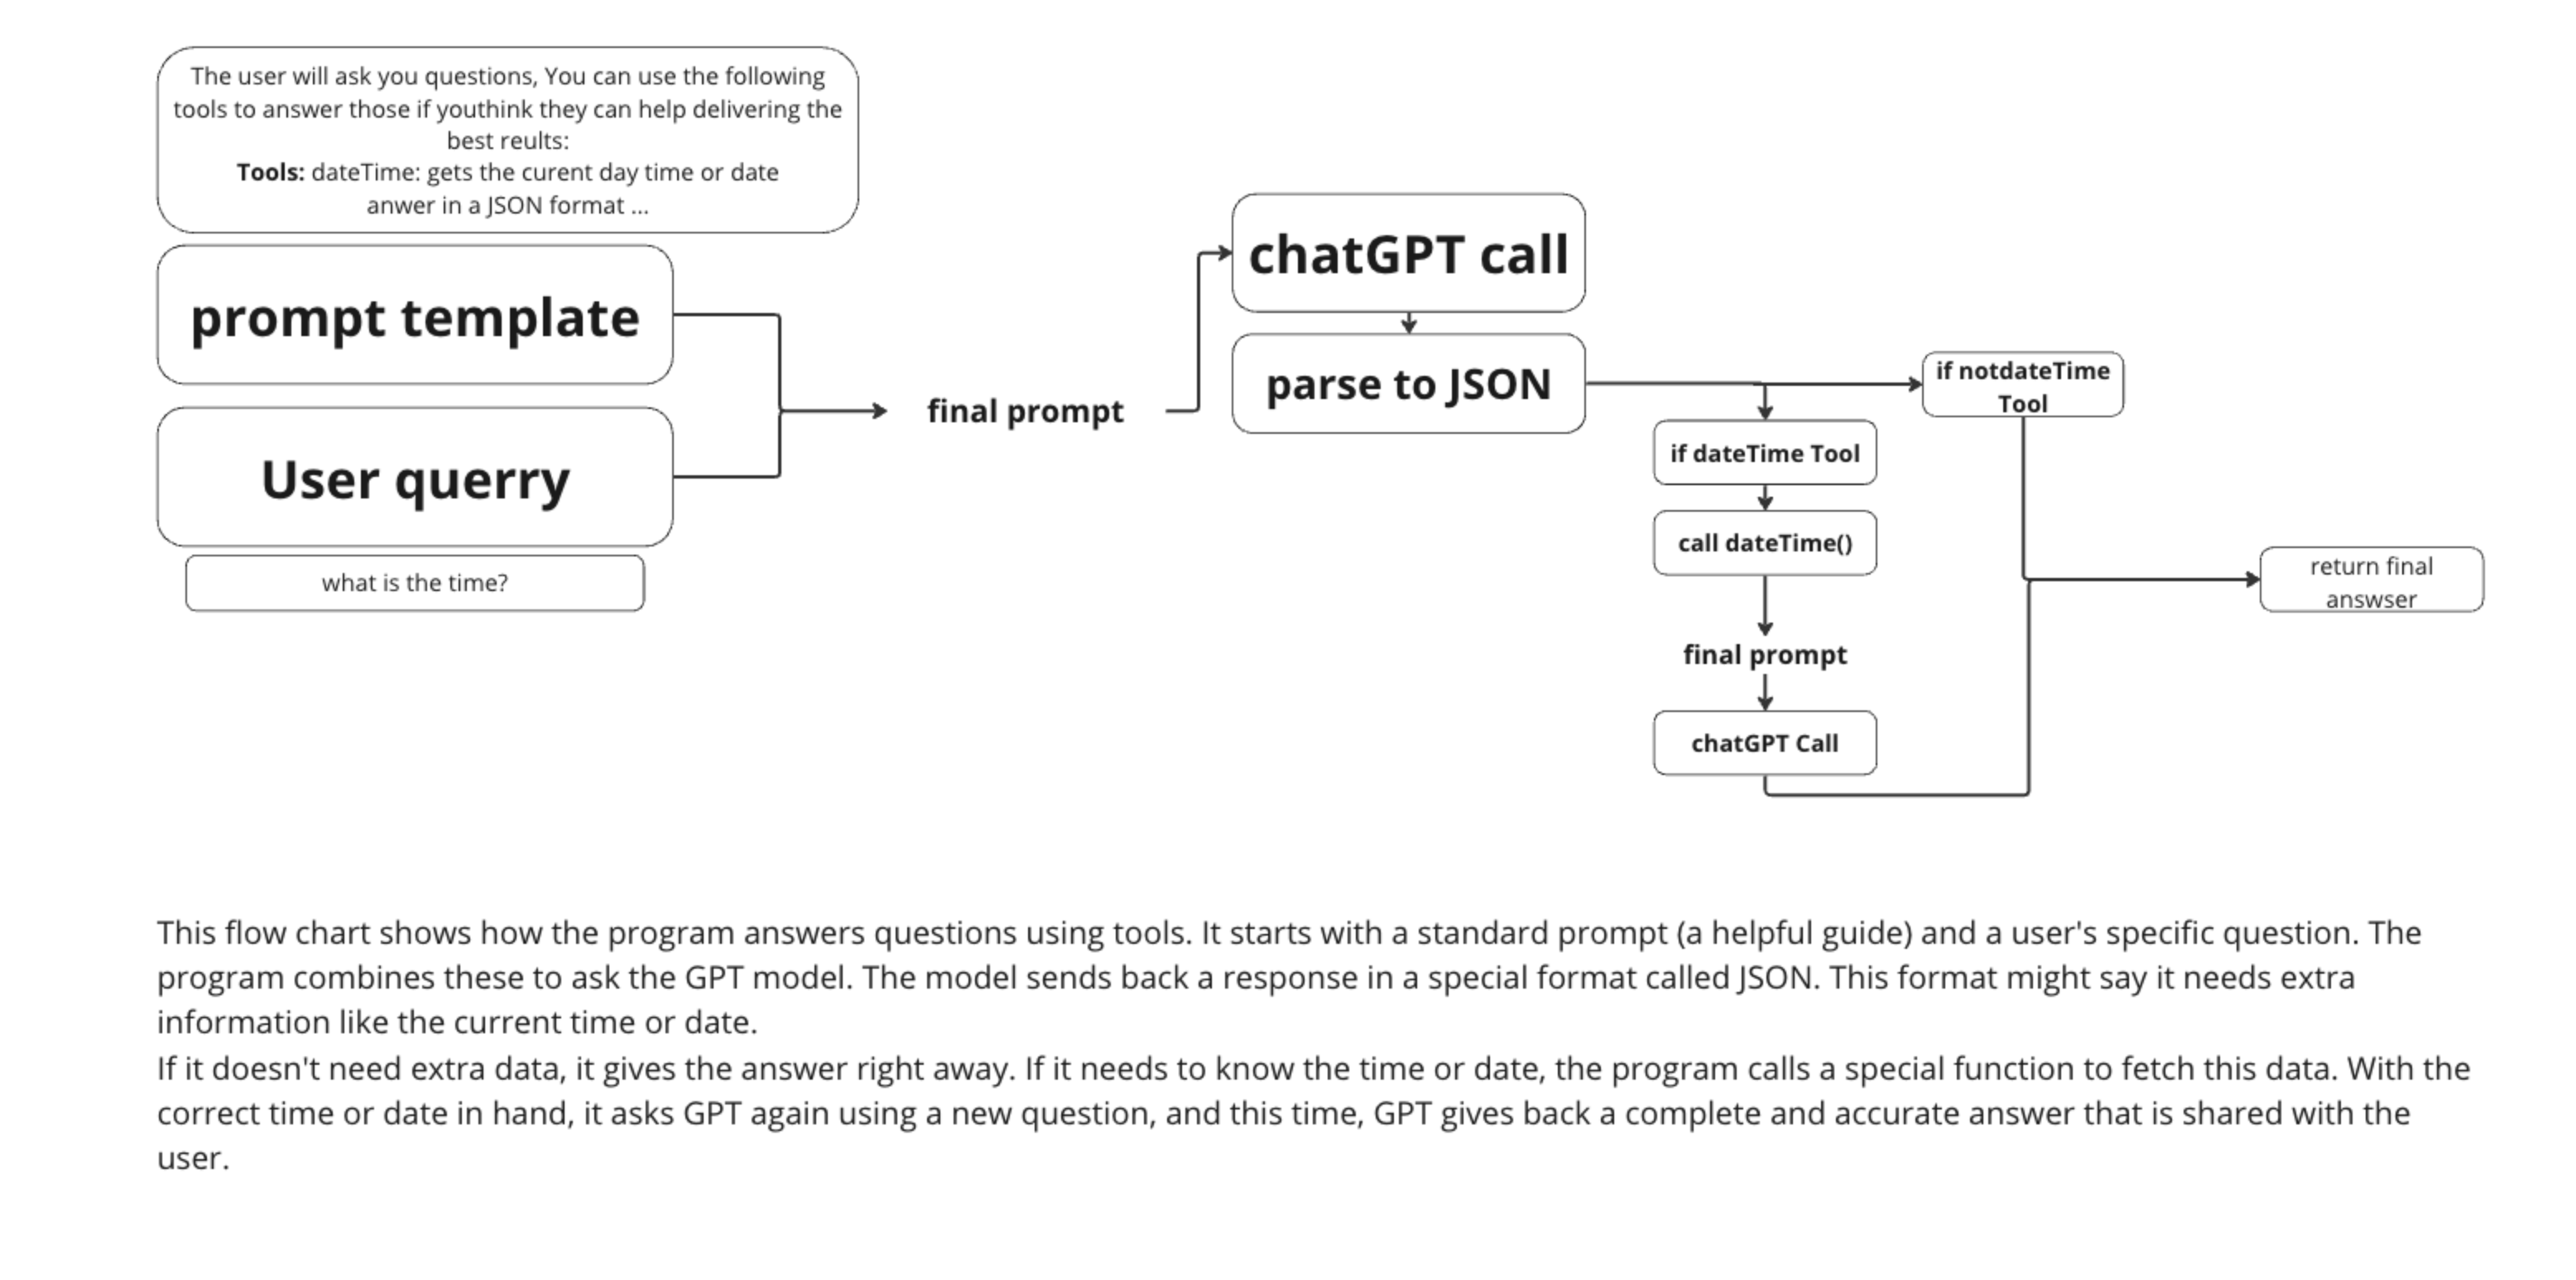



**lets break down the intention behind the prompt_template:**

```
prompt_template = """
You are a helpfull assistant. Try your best to fullfill the user query. To empower
you further you can use the "getTime" tool. in oder to use it answer in the following
JSON format:

{"message":"your regular message to  the user",
"tool":"getTime"
"args":{"time_type":"date"}
}

if you dont need to use the tool  leave "tool" and "args" empty. If you use the tool
use the message field to explain your argument choices.
The argument time_type can either be "date" (to get the current y:m:d) or
day_time to the the current time (h:m:s).

Ensure to always answer in exactly that json fomrat. Do not add any comments or thoughts.
Below is the user query:
"""
```





1. **Introduction:** Guides GPT to be a helpful assistant with a specific purpose.
2. **Tool Description:** Introduces the tool to be used ("getTime"), raising GPT's awareness of its purpose.
3. **Example JSON Response:**
   - `"message"`: GPT's regular message to the user.
   - `"tool"`: Specifies the tool used, if applicable.
   - `"args"`: Arguments needed for the tool to work.
4. **Tool Argument Explanation:** Explains possible arguments for `time_type`.
5. **Conditional Use Instructions:** Leaves `"tool"` and `"args"` empty if no tool is needed.
6. **Final Reminder and User Query Context:** Emphasizes the JSON response format and invites a user query.


In [ ]:
# lets use the arguments to actually call the function
user_prompt = "Whats the capital of spain today?"
final_prompt = prompt_template + user_prompt
res = callGPT(final_prompt)
print("Response from GPT:", res)

try:
    resdict = json.loads(res)
    print("Parsed response dictionary:", resdict)

    if resdict.get("tool") == "getTime":
        timeType = resdict["args"]["time_type"]
        curTime = getTime(timeType)
        print("timeType:", timeType)

        # Conduct second API call to provide the user with the complete answer
        promptWithData = f"""
        This is the result of using the getTime tool with the argument <{timeType}>: <{curTime}>.
        Use the information to answer the user query: {user_prompt}, answer in a JSON format in this format {{"message":""}}.
        """

        finalRes = callGPT(promptWithData)
        print("Final outcome:", finalRes)
    else:
        print("Message:", resdict.get("message"))
except json.JSONDecodeError:
    print("Failed to parse JSON response:", res)
except KeyError as e:
    print(f"KeyError - missing key: {e}")
except TypeError as e:
    print(f"TypeError: {e}")

Response from GPT: 
{"message":"Madrid",
"tool":"getTime",
"args":{"time_type":"date"}
}
Parsed response dictionary: {'message': 'Madrid', 'tool': 'getTime', 'args': {'time_type': 'date'}}
timeType: date
Final outcome: {"message":"The current capital of Spain is Madrid."}


**Lets break down the workflow logic**
1. **Initial Prompt and Response**:
   - Combines a prompt template with a user query ("What's the capital of Spain today?") and calls GPT using `callGPT`.
   - Parses the response to identify whether `getTime` is needed.

2. **Tool Usage**:
   - If the tool `getTime` is requested, retrieves the required data (either date or time) and prints the argument type.

3. **Second API Call for Full Answer**:
   - Constructs a follow-up prompt that includes the retrieved `getTime` data.
   - Calls `callGPT` again to generate a final response, now incorporating the accurate date or time information.

4. **Fallback Handling**:
   - If the response doesn't require `getTime`, prints the initial response message directly.

## TASK II: Add natural language control spatial analysis

Now its time for you to adopt the logic to the spatial analysis example from one of the previous classes. See Stasyas Notebook: https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/02_osm_data.ipynb#scrollTo=-7vrUW-fOsRT




---



The goal is to enable chatGPT to look up the shortest route between an  origina and destination and return a map with that route.  

I have prepared the basic setup for you including a python function to:
1. fetch and download street network data for a given area
2. compute the shortest path between a origin and destination
3. returns a map of that.

Furthermore, similar to the getTime example above I prepared a logic where this function can be called by chatGPT.

**Your Taks:**

**A:** Complete and tweak the prompt_template so that chatGPT can derive when it needs to use the function to answer a user question and that it provides you with the necesarry information (e.g. addresses of origin and destination) you need to call the getRoute function successfully.

You get get some inspiration from the prompt template of the getTime example

**B:** In the last colab cell (GPT Workflow), add the code to extract the necesarry information from the chat gpt response and pass it to the getRoute function

In [7]:
# additional imports
!pip install osmnx geopy scikit-learn
import geopandas
import matplotlib.pyplot as plt
import osmnx
import seaborn as sns
from shapely.geometry import Point, LineString

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
def callGPT(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "user", "content": messages}],
    )
    return response.choices[0].message.dict()["content"]

**TODO**  complete and tweak prompt template

In [ ]:
prompt_template = """
The user will ask you questions, You can use the following tools to answer those if you think they can help delivering the best reults:
Tools:
"plotRoute": this tool allows you to find the shortest path between an origin and a destination address.
The tool has the following arguments/inputs you need to derive from the user request as good as possible. The tool will return the travel time, travel distance, and a map of the route.

Inputs: origin (address name),
destination  (address name),
regionName (region),
travelMode (car, bike, pedestrian)

You have to return your answer in the following format:
{
 "message": <your normal message>,
"tool": <the tool you want to use>,
"args":{
 "origin":<origin address>,
"destination":<destination address>,
"regionName": <name of the region>,
"travelMode":<mode of travel>
}
}

Try your best to derive addresses that work well with open streen map place namings. For "travelMode" you are only allowed to choose betwee [car, bike, pedestrian].
In case you do not want to use any tool, leave "tool" and "args" empty.

heres the user question:

"""

Create Function to:
1. Get the street network / graph for a certain region
2. geocodes a origin  & destination address and matches that to a position on the network
3. calculates the shortest path between origin and destination
4. returns and creates a visualisation of this path

In [8]:
from osmnx import routing

# Define average speeds for different modes of travel (in km/h)
average_speeds = {
    'drive': 30,    # Average driving speed (km/h)
    'bike': 15,     # Average biking speed (km/h)
    'walk': 5       # Average walking speed (km/h)
}

def getRoute(originName, destinationName, placeName, travelModes=['drive', 'bike', 'walk']):
    """
    Find the shortest route between two locations using OSMnx for multiple travel modes.

    Parameters:
    - originName (str): The name of the origin location.
    - destinationName (str): The name of the destination location.
    - placeName (str): The name of the region to search within.
    - travelModes (list): List of travel modes to consider. Default: ['drive', 'bike', 'walk'].

    Returns:
    - routes (dict): Dictionary containing routes, travel times, distances, and modes for each travel mode.
    """
    routes = {}

    try:
        for mode in travelModes:
            # Fetching graph data
            graph = osmnx.graph_from_place(placeName, network_type=mode)
            nodes, edges = osmnx.graph_to_gdfs(graph)

            # Geocoding origin and destination
            origin = (
                osmnx.geocode_to_gdf(originName)
                .to_crs(edges.crs)
                .at[0, "geometry"]
                .centroid
            )

            destination = (
                osmnx.geocode_to_gdf(destinationName)
                .to_crs(edges.crs)
                .at[0, "geometry"]
                .centroid
            )

            # Finding nearest nodes
            origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
            destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

            # Calculating the shortest path
            route = osmnx.shortest_path(graph, origin_node_id, destination_node_id, weight='length')

            # Converting the route to a GeoDataFrame
            route_gdf = routing.route_to_gdf(graph, route)

            # Calculating travel time and distance
            total_distance = route_gdf['length'].sum() / 1000  # in kilometers
            travelTime = total_distance / average_speeds[mode] * 60  # in minutes

            # Storing route information in the dictionary
            routes[mode] = {
                'route': route,
                'travelTime': travelTime,
                'travelDistance': total_distance
            }

    except Exception as e:
        print(f"An error occurred: {e}")

    return routes


Lets test the function by manually inserting parameter
(might take a while since it needs to download the osm data first)

Routes: {'drive': {'route': [30313010, 30312832, 506151644, 243338866, 4385157799, 30689544, 2291722043, 2238485654, 262251754, 382063655, 4385479227, 4385157797, 415989799], 'travelTime': 2.75995, 'travelDistance': 1.379975}, 'bike': {'route': [2764460286, 2764460284, 243338866, 4385157799, 30689544, 2291722043, 2238485654, 8122048078, 4952629849, 382063655, 4385479227, 506223374, 4385157797, 415989799], 'travelTime': 4.428436, 'travelDistance': 1.107109}, 'walk': {'route': [7862503724, 30313010, 6225821940, 5003912587, 365565045, 5451351933, 6225821935, 442870114, 30689544, 8242269338, 8498380072, 2291722043, 8498380069, 8122048081, 2238485654, 8122048078, 6225821671, 262251754, 8122048073, 382063655, 8122048072, 6225821672, 4385479227, 8122247189, 2034764964, 4385157797, 5764490171, 6225821674, 415989799], 'travelTime': 13.254756000000002, 'travelDistance': 1.1045630000000002}}
Mode: drive, Travel Time: 2.75995 minutes, Travel Distance: 1.379975 km


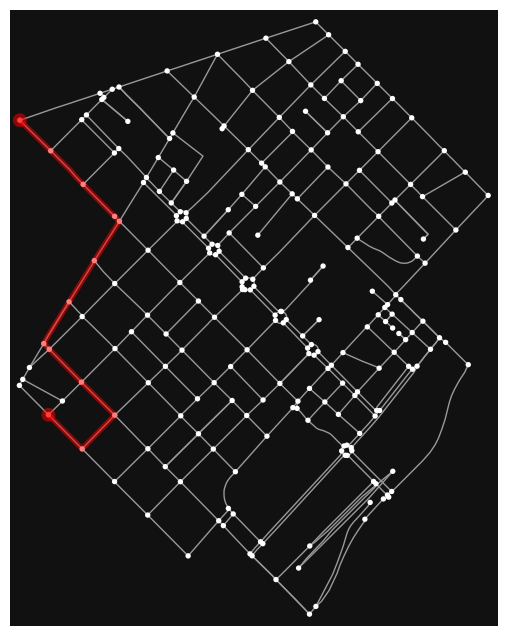

Mode: bike, Travel Time: 4.428436 minutes, Travel Distance: 1.107109 km


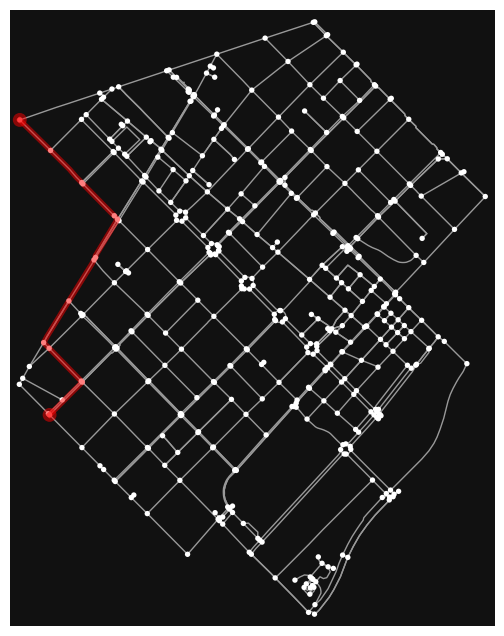

Mode: walk, Travel Time: 13.254756000000002 minutes, Travel Distance: 1.1045630000000002 km


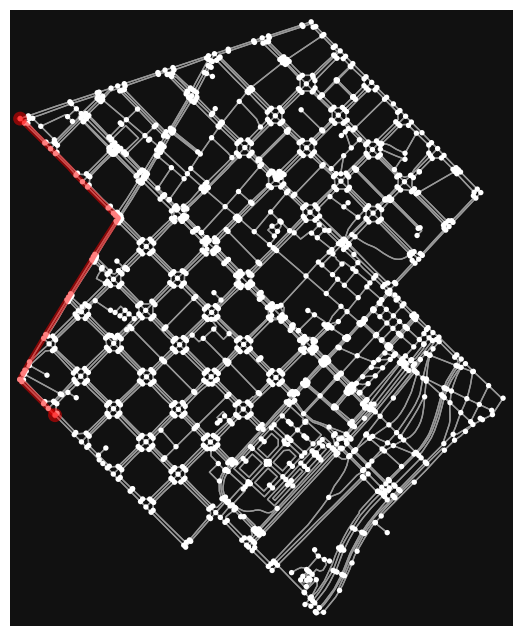

In [ ]:
# Call the getRoute function
routes = getRoute("Institute for Advanced Architecture of Catalonia", "Torre Glories", "el Poblenou, Barcelona, Spain")

# Print the routes dictionary
print("Routes:", routes)

# Plot the routes
if routes:
    for mode, route_info in routes.items():
        print(f"Mode: {mode}, Travel Time: {route_info['travelTime']} minutes, Travel Distance: {route_info['travelDistance']} km")
        # Fetch the graph again based on the network type (mode)
        graph = osmnx.graph_from_place("el Poblenou, Barcelona, Spain", network_type=mode)
        # Plot the route
        osmnx.plot_graph_route(graph, route_info['route'])



Separate Graphs for Each Type of Mode of Travel

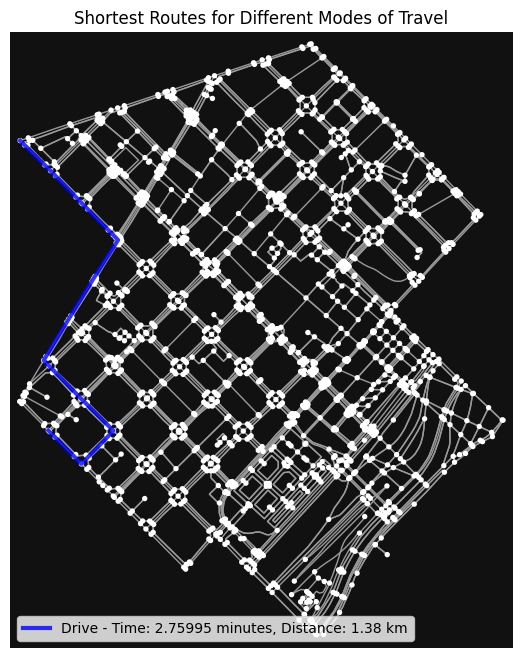

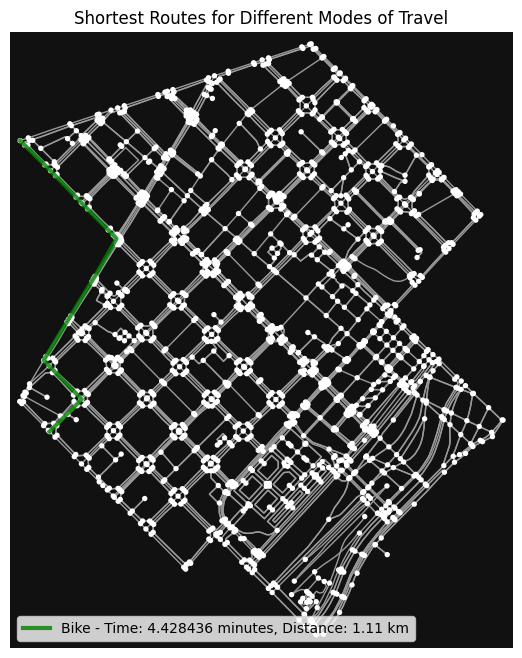

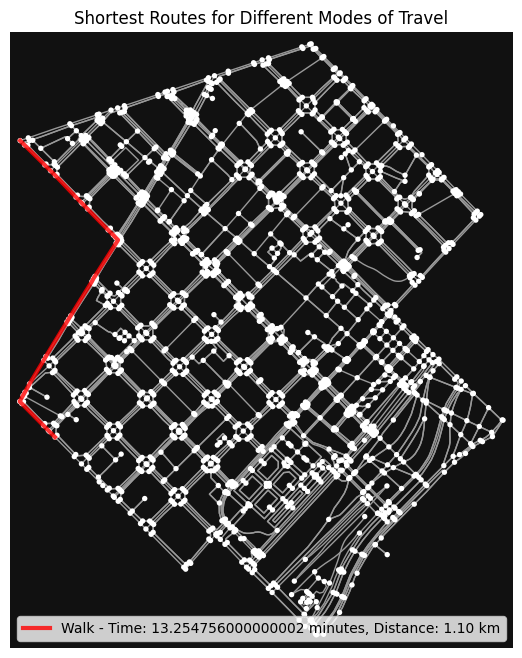

In [ ]:
# Call the getRoute function
routes = getRoute("Institute for Advanced Architecture of Catalonia", "Torre Glories", "el Poblenou, Barcelona, Spain")

# Create a single graph object
graph = osmnx.graph_from_place("el Poblenou, Barcelona, Spain", network_type='all')

# Plot the routes on the graph
if routes:
    for mode, route_info in routes.items():
        # Create a line string geometry from the route nodes
        route_nodes = [node for node in route_info['route'] if node in graph.nodes]
        route_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in route_nodes]
        route_line = LineString(route_coords)

        # Plot the route with a different color for each mode
        color = {'drive': 'blue', 'bike': 'green', 'walk': 'red'}[mode]
        osmnx.plot_graph(graph, show=False)
        plt.plot(*route_line.xy, color=color, linewidth=3, alpha=0.8, label=f"{mode.capitalize()} - Time: {route_info['travelTime']} minutes, Distance: {route_info['travelDistance']:.2f} km")
# Add title and legend
        plt.title("Shortest Routes for Different Modes of Travel")
        plt.legend()


# Show the plot
plt.show()



A Single Graph for All Types of Mode of Travel

FIXED CODES

In [9]:
average_speeds = {
    'drive': 30,    # Average driving speed in km/h
    'bike': 15,     # Average biking speed in km/h
    'walk': 5       # Average walking speed in km/h
}

def getRoute(origin, destination, regionName, travelMode=['drive', 'bike', 'walk']):
    if not isinstance(travelMode, list):
        travelMode = [travelMode]

    routes = {}

    try:
        for mode in travelMode:
            # Fetching graph data
            graph = osmnx.graph_from_place(regionName, network_type=mode)
            nodes, edges = osmnx.graph_to_gdfs(graph)

            # Geocoding origin and destination
            try:
                origin_gdf = osmnx.geocode_to_gdf(origin)
                origin_geo = origin_gdf.to_crs(edges.crs).iloc[0].geometry.centroid
            except Exception as e:
                print(f"An error occurred while geocoding the origin: {e}")
                continue

            try:
                destination_gdf = osmnx.geocode_to_gdf(destination)
                destination_geo = destination_gdf.to_crs(edges.crs).iloc[0].geometry.centroid
            except Exception as e:
                print(f"An error occurred while geocoding the destination: {e}")
                continue

            # Finding nearest nodes
            origin_node_id = osmnx.distance.nearest_nodes(graph, X=origin_geo.x, Y=origin_geo.y)
            destination_node_id = osmnx.distance.nearest_nodes(graph, X=destination_geo.x, Y=destination_geo.y)

            # Calculating the shortest path
            route = osmnx.shortest_path(graph, origin_node_id, destination_node_id, weight='length')

            # Converting the route to a GeoDataFrame
            route_gdf = osmnx.routing.route_to_gdf(graph, route)

            # Calculating travel time and distance
            total_distance = route_gdf['length'].sum() / 1000  # in kilometers
            travelTime = total_distance / average_speeds[mode] * 60  # in minutes

            # Storing route information in the dictionary
            routes[mode] = {
                'route': route,
                'route_gdf': route_gdf,
                'travelTime': travelTime,
                'travelDistance': total_distance
            }

    except Exception as e:
        print(f"An error occurred: {e}")

    return routes


In [41]:
from IPython.display import Image

def plotRoute(origin, destination, regionName, travelMode=['drive', 'bike', 'walk'], filename="route_plot.png"):
    routes = getRoute(origin, destination, regionName, travelMode)

    # Create a single graph object
    graph = osmnx.graph_from_place(regionName, network_type='all')
    fig, ax = osmnx.plot_graph(graph, show=False, close=False)

    # Plot the routes on the graph
    if routes:
        for mode, route_info in routes.items():
            if 'route_gdf' not in route_info:
                continue
            route_gdf = route_info['route_gdf']

            # Plot the route with a different color for each mode
            color = {'drive': 'blue', 'bike': 'green', 'walk': 'red'}[mode]
            route_gdf.plot(ax=ax, color=color, linewidth=3, alpha=0.8, label=f"{mode.capitalize()} - Time: {route_info['travelTime']:.1f} minutes, Distance: {route_info['travelDistance']:.2f} km")

            # Print travel distance and time
            print(f"Travel Distance ({mode}): {route_info['travelDistance']:.2f} km")
            print(f"Travel Time ({mode}): {route_info['travelTime']:.1f} minutes")

    # Add title and legend
    plt.title("Shortest Routes for Different Modes of Travel")
    plt.legend()

    # Save the plot as an image file
    plt.savefig(filename)

    # Display the image
    display(Image(filename))

    # Close the plot to free up memory
    plt.close()

    return filename


Travel Distance (drive): 0.65 km
Travel Time (drive): 1.3 minutes
Travel Distance (bike): 0.65 km
Travel Time (bike): 2.6 minutes
Travel Distance (walk): 0.36 km
Travel Time (walk): 4.3 minutes


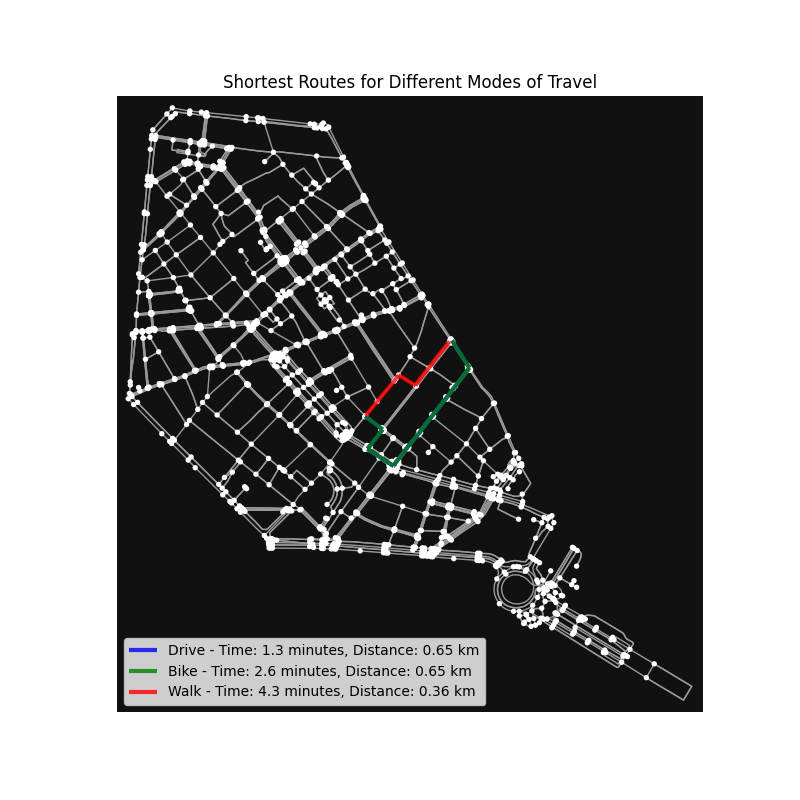

'route_plot.png'

In [42]:
plotRoute("Gran Teatre del Liceu", "Filmoteca de Catalunya", "el Raval, Barcelona, Spain")

**GPT WORKFLOW**

Create Workflow where chatGPT has the option to call the routing function if needed.

**TODO:** Extract the information from the chatGPT response and pass it to the getRoute function

In [21]:
import re
# Define a function to parse the user question based on the prompt template
def parse_user_question(user_question):
    parsed_info = {}

    # Define regular expressions to extract information
    origin_pattern = r"from ([\w\s]+) to"
    destination_pattern = r"to ([\w\s]+) in"
    region_pattern = r"in\s+([\w\s,]+)by"
    travel_mode_pattern = r"by\s+([\w]+)"

    # Extract origin, destination, region name, and travel mode using regular expressions
    origin_match = re.search(origin_pattern, user_question, re.IGNORECASE)
    destination_match = re.search(destination_pattern, user_question, re.IGNORECASE)
    region_match = re.search(region_pattern, user_question, re.IGNORECASE)
    travel_mode_match = re.search(travel_mode_pattern, user_question, re.IGNORECASE)

    # Check if matches were found and extract information
    if origin_match:
        parsed_info['origin'] = origin_match.group(1).strip()
    if destination_match:
        parsed_info['destination'] = destination_match.group(1).strip()
    if region_match:
        parsed_info['regionName'] = region_match.group(1).strip()
    if travel_mode_match:
        parsed_info['travelMode'] = travel_mode_match.group(1).strip()

    return parsed_info

In [43]:
def callGPT(user_question, model="gpt-3.5-turbo-1106", response_format={"type": "json_object"}):
    # Parse the user's response
    parsed_info = parse_user_question(user_question)

    # Combine the parsed information with the prompt template
    prompt = f"""
    The user will ask you questions. You can use the following tools to answer those if you think they can help deliver the best results:

    Tools:
    "plotRoute": This tool allows you to find the shortest path between an origin and a destination address and plot the different routes on a map.
    The tool has the following arguments/inputs you need to derive from the user request as well as possible. The tool will return the travel time, travel distance, and a map of the route.

    Inputs:
    origin: {parsed_info['origin']},
    destination: {parsed_info['destination']},
    regionName: {parsed_info['regionName']},
    travelMode: {parsed_info['travelMode']}

    You have to return your answer in the following format:
    {{
        "message": <your normal message>,
        "tool": "plotRoute",
        "args": {{
            "origin": <origin address>,
            "destination": <destination address>,
            "regionName": <name of the region>,
            "travelMode": <mode of travel>,
            "plot": True
        }}
    }}

    Try your best to derive addresses that work well with OpenStreetMap place namings. For "travelMode", you are only allowed to choose between [drive, bike, walk].
    If the response indicates to plot the graph, plot it then display the image of the plot
    In case you do not want to use any tool, leave "tool" and "args" empty.
    Ensure to always answer in exactly that json format. Do not add any comments or thoughts.
    Here's the user question:
    {user_question}
    """

    # Call the GPT model
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "user", "content": prompt}],
    )

    # Get the content of the response
    content = response.choices[0].message

    # Print the content for debugging
    print("Response Content:", content)

    # If the response indicates to plot the graph, plot it
    if isinstance(content, dict) and content.get("tool") == "plotRoute" and content.get("args", {}).get("plot", False):
        filename = plotRoute(parsed_info['origin'], parsed_info['destination'], parsed_info['regionName'], [parsed_info['travelMode']])
        display(Image(filename))  # Display the saved image file

    # Return the content of the response
    return content


In [45]:
# Sample user input
user_question = "What is the shortest route from Gran Teatre del Liceu to Filmoteca de Catalunya in el Raval by walk?"

# Call the callGPT function
response = callGPT(user_question)

# Print the response
print("GPT Response:", response)

Response Content: ChatCompletionMessage(content='{\n    "message": "The shortest route from Gran Teatre del Liceu to Filmoteca de Catalunya in el Raval by walk is approximately 1.2 kilometers.",\n    "tool": "plotRoute",\n    "args": {\n        "origin": "Gran Teatre del Liceu",\n        "destination": "Filmoteca de Catalunya",\n        "regionName": "el Raval",\n        "travelMode": "walk",\n        "plot": true\n    }\n}', role='assistant', function_call=None, tool_calls=None)
GPT Response: ChatCompletionMessage(content='{\n    "message": "The shortest route from Gran Teatre del Liceu to Filmoteca de Catalunya in el Raval by walk is approximately 1.2 kilometers.",\n    "tool": "plotRoute",\n    "args": {\n        "origin": "Gran Teatre del Liceu",\n        "destination": "Filmoteca de Catalunya",\n        "regionName": "el Raval",\n        "travelMode": "walk",\n        "plot": true\n    }\n}', role='assistant', function_call=None, tool_calls=None)


In [37]:
!ls route_plot.png

route_plot.png


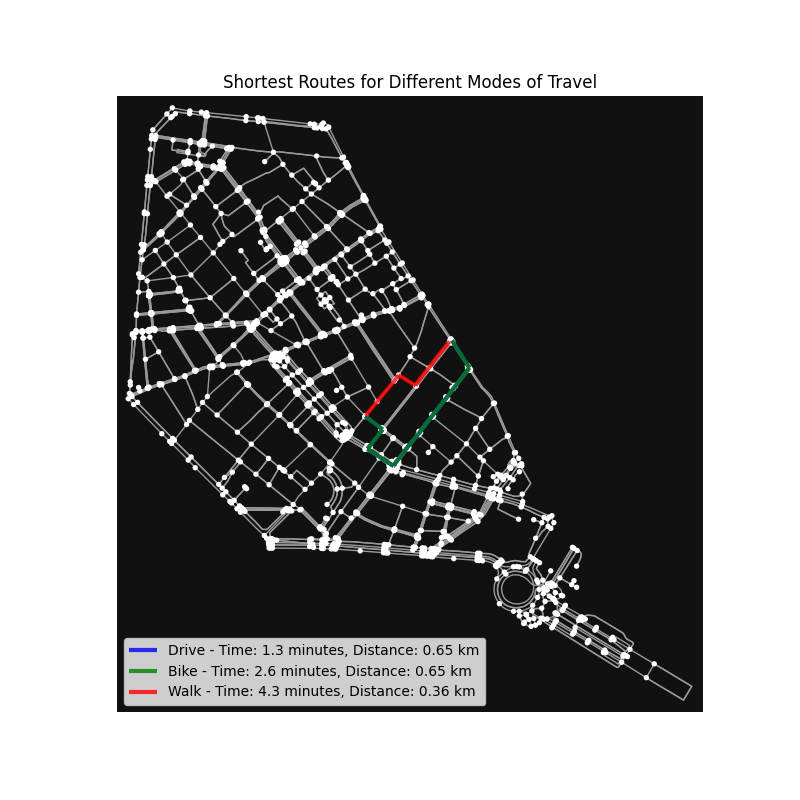

In [38]:
from IPython.display import Image
Image("route_plot.png")